# Classic CV

## Packages

In [32]:
import os
import math

import cv2
from cv2 import bitwise_and, bitwise_xor
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import frangi, meijering, sato
from skimage.restoration import denoise_tv_chambolle
from sklearn.metrics import confusion_matrix

## Import data

In [2]:
path = '../data/HRF/'
files = sorted(os.listdir(path))
data = {
    'original': [],
    'labeled': [],
    'mask': []
}
for file in files:
    if file.endswith('h.jpg'):
        data['original'].append(cv2.imread(f'{path}{file}')/255.0)
    elif file.endswith('h.tif'):
        data['labeled'].append(cv2.imread(f'{path}{file}',0)/255.0)
    elif file.endswith('h_mask.tif'):
        data['mask'].append(cv2.imread(f'{path}{file}',0)/255.0)

In [3]:
for type_ in data:
    print(len(data[type_]))
    print(data[type_][0].shape)

15
(2336, 3504, 3)
15
(2336, 3504)
15
(2336, 3504)


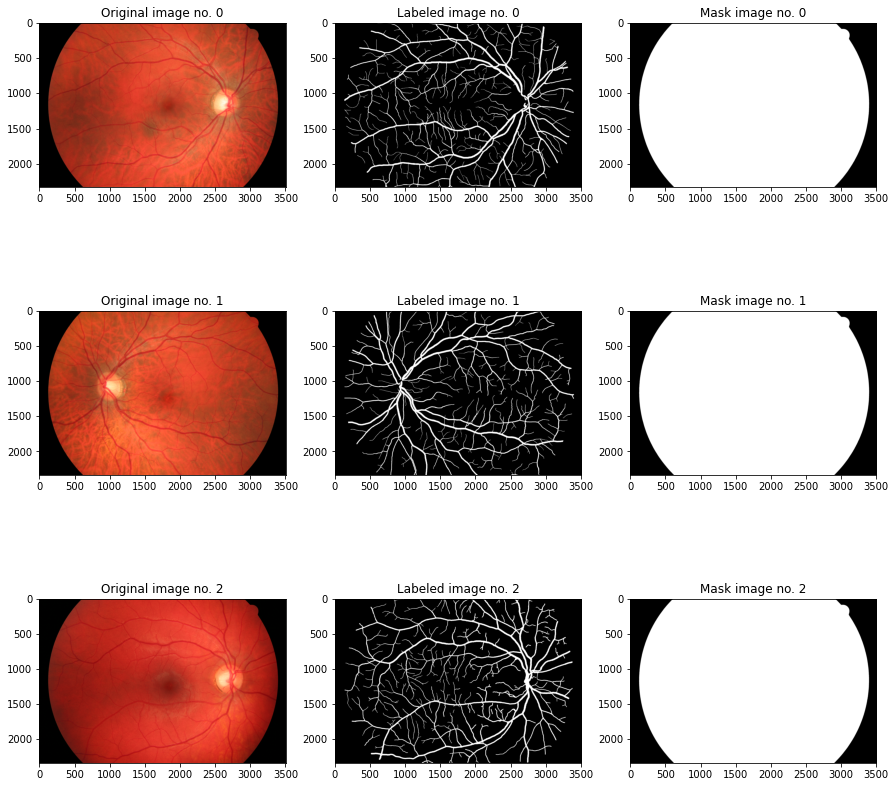

In [4]:
columns, rows = 3, 3
plt.figure(figsize=(5*columns, 5*rows))

for i in range(0, columns*rows):
    plt.subplot(rows, columns, i+1)
    number = int(i/3)
    if i%3 == 0:
        img = data['original'][number]
        plt.title(f'Original image no. {number}')
        plt.imshow(img[:,:,::-1])
    elif i%3 == 1:
        img = data['labeled'][number]
        plt.title(f'Labeled image no. {number}')
        plt.imshow(img, cmap='gray')
    elif i%3 == 2:
        img = data['mask'][number]
        plt.title(f'Mask image no. {number}')
        plt.imshow(img, cmap='gray')
plt.show()

## Analysis

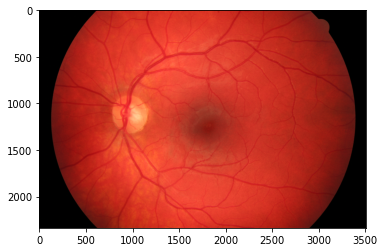

In [5]:
testing_subject, testing_subject_labeled, testing_subject_mask = data['original'][3], data['labeled'][3], data['mask'][3]
plt.imshow(testing_subject[:,:,::-1])

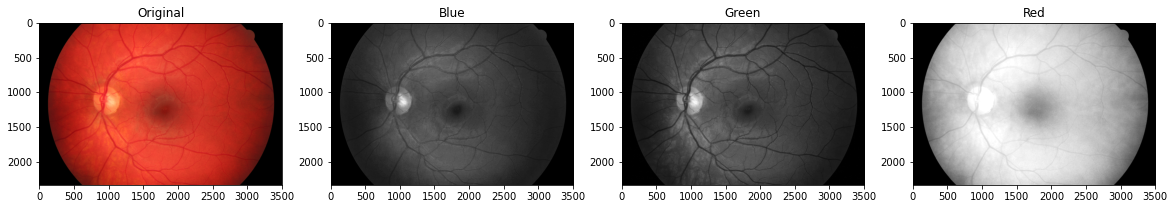

In [6]:
testing_subject_color = {'b': testing_subject[:,:,0], 'g': testing_subject[:,:,1], 'r': testing_subject[:,:,2]}

plt.figure(figsize=(20,12))
subplots = [1, 2, 3, 4]
titles = ['Original', 'Blue', 'Green', 'Red']
channels = ['all', 'b', 'g', 'r']

for subplot, title, channel in zip(subplots, titles, channels):
    plt.subplot(1, 4, subplot)
    if channel == 'all':
        plt.imshow(testing_subject[:,:,::-1])
    else:
        plt.imshow(testing_subject_color[channel], cmap='gray')
    plt.title(title)

## Functions

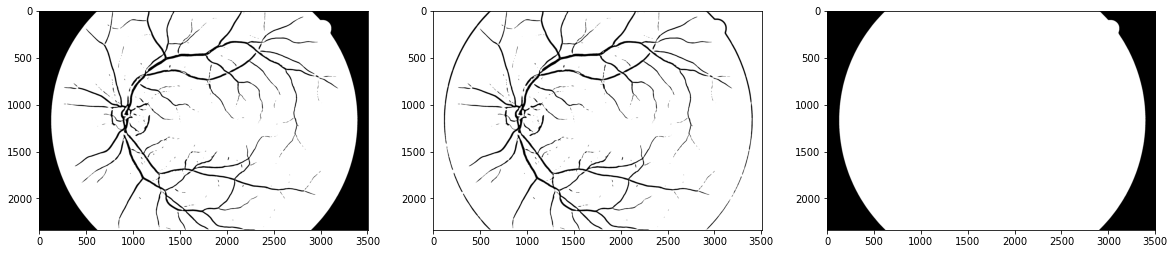

In [85]:
plt.figure(figsize=(20,12))
def remove_noise(image):
    # noise_mask = np.ones(image.shape[:2], dtype="uint8")
    # contours, hierarchy = cv2.findContours(image.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    # for contour in contours:
    #     if cv2.contourArea(contour) <= 200:
    #         cv2.drawContours(noise_mask, [contour], -1, 0, -1)
    return denoise_tv_chambolle(image, weight=0.1, channel_axis=-1)

def create_result(image, mask):
    filtered = frangi(image)
    filtered_min, filtered_max = filtered.min(), filtered.max()
    image = (1-(filtered-filtered_min)/(filtered_max-filtered_min))
    _, image = cv2.threshold(image, 0.95, 1, cv2.THRESH_BINARY)
    _, new_image = cv2.threshold(image+mask-1, 0.95, 1, cv2.THRESH_BINARY)
    return new_image, image, mask
test_image, old_image, mask = create_result(testing_subject_color['g'], testing_subject_mask)
# plt.imshow(test_image, cmap='gray')
plt.subplot(131)
plt.imshow(test_image, cmap='gray')
plt.subplot(132)
plt.imshow(old_image, cmap='gray')
plt.subplot(133)
plt.imshow(mask-1, cmap='gray')

In [81]:
testing_subject_mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Metrics

In [24]:
def get_metrics(result, real):
    conf = confusion_matrix(result.flatten(), real.flatten())
    TN, FP, FN, TP = conf.ravel()

    accuracy = 1.0 *(TP + TN) / (TP + TN + FP + FN)
    sensitivity = 1.0 * TP / (TP + FN)
    specificity = 1.0 * TN / (TN + FP)

    return accuracy, sensitivity, specificity

In [86]:
get_metrics(test_image, testing_subject_labeled)

(0.2090672059720398, 0.06395600819348467, 0.7853603726715619)

In [ ]:
for threshold in range(900,999, 5):
    #test thresholda
    #10 obrazków
    #srednia z wynikow
    #pokazac kazda metryke na wykresie